In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime
from sklearn import preprocessing

In [4]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [5]:
train = load_df('train.csv')
test = load_df('test.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

train date: 20160801 to 20170801
test date: 20170802 to 20180430


In [6]:
for c in train.columns.values:
    if c not in test.columns.values: print(c)

totals.transactionRevenue
trafficSource.campaignCode


In [7]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'].astype(float))
print(train['totals.transactionRevenue'].describe())

count    903653.000000
mean          0.227118
std           2.003710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.864375
Name: totals.transactionRevenue, dtype: float64


In [30]:
all_data = train.append(test, sort=False).reset_index(drop=True)

In [31]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                                   100
totals.newVisits                                200593
totals.bounces                                  453023
trafficSource.keyword                           502929
trafficSource.referralPath                      572712
trafficSource.isTrueDirect                      629648
trafficSource.adwordsClickInfo.gclId            882092
trafficSource.adwordsClickInfo.adNetworkType    882193
trafficSource.adwordsClickInfo.isVideoAd        882193
trafficSource.adwordsClickInfo.page             882193
trafficSource.adwordsClickInfo.slot             882193
trafficSource.adContent                         892707
trafficSource.campaignCode                      903652
dtype: int64


In [32]:
all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int)

# fillna boolean feature
all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [33]:
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
#for c in constant_column:
#    print(c + ':', train[c].unique())

print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['socialEngagementType', 'device.browserSize', 'device.browserVersion', 'device.flashVersion', 'device.language', 'device.mobileDeviceBranding', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.operatingSystemVersion', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.campaignCode']


In [34]:
format_str = '%Y%m%d'
all_data['formated_date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_month'] = all_data['formated_date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['formated_date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['formated_date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['formated_date'].apply(lambda x:x.weekday())

all_data.drop(['date','formated_date'], axis=1, inplace=True)


In [35]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.plot.barh()


In [36]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

In [37]:
print('train all sessionId:', len(train['sessionId']))
print('train unique sessionId:', train['sessionId'].nunique())

train all sessionId: 903653
train unique sessionId: 902755


In [38]:
print(all_data['totals.hits'].value_counts()[:10])

all_data['totals.hits'] = all_data['totals.hits'].astype(int)

1     864064
2     237499
3     134435
4      80875
5      63687
6      46598
7      38137
8      29717
9      24999
10     20306
Name: totals.hits, dtype: int64


In [39]:
print(all_data['totals.pageviews'].value_counts()[:10])

all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)


1     876567
2     249794
3     142896
4      86666
5      64712
6      47721
7      37751
8      29586
9      24153
10     19228
Name: totals.pageviews, dtype: int64


In [41]:
train_rev = train[~train['totals.transactionRevenue'].isnull()].copy()


unique trafficSource.adContent count: 44


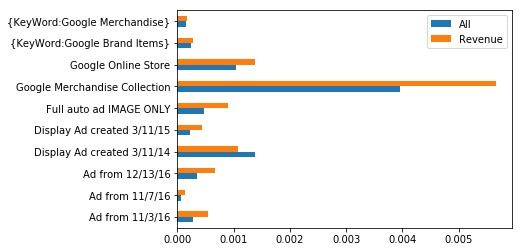

In [43]:


all_data['_adContentGMC'] = (all_data['trafficSource.adContent'] == 'Google Merchandise Collection').astype(np.uint8)

unique trafficSource.campaign count: 10


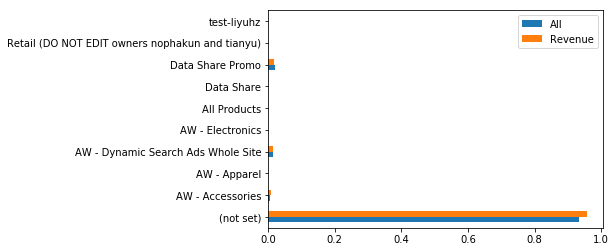

In [44]:
print('unique trafficSource.campaign count:', train['trafficSource.campaign'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.campaign', 10)

all_data['_withCampaign'] = (all_data['trafficSource.campaign'] != '(not set)').astype(np.uint8)

unique trafficSource.referralPath count: 1475


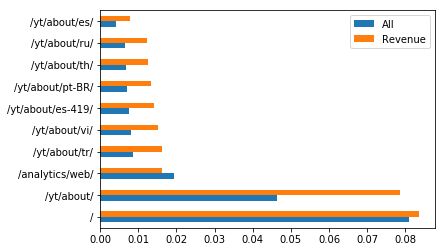

In [45]:
print('unique trafficSource.referralPath count:', train['trafficSource.referralPath'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.referralPath', 10)

all_data['_referralRoot'] = (all_data['trafficSource.referralPath'] == '/').astype(np.uint8)


unique trafficSource.source count: 380


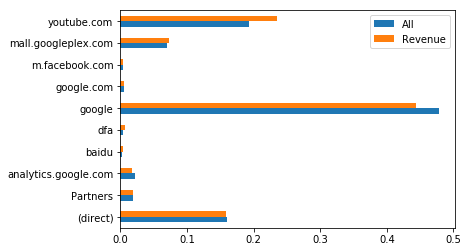

In [46]:
print('unique trafficSource.source count:', train['trafficSource.source'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.source', 10)

all_data['_sourceGpmall'] = (all_data['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)

In [47]:
all_data['_meanHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('mean')
all_data['_meanHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('mean')
all_data['_meanHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('mean')
all_data['_sumHitsPerDay'] = all_data.groupby(['_day'])['totals.hits'].transform('sum')
all_data['_sumHitsPerWeekday'] = all_data.groupby(['_weekday'])['totals.hits'].transform('sum')
all_data['_sumHitsPerMonth'] = all_data.groupby(['_month'])['totals.hits'].transform('sum')

for feature in ['totals.hits', 'totals.pageviews']:
    info = all_data.groupby('fullVisitorId')[feature].mean()
    all_data['_usermean_' + feature] = all_data.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = all_data.groupby('fullVisitorId')[feature].max()
    all_data['_usermax_' + feature] = all_data.fullVisitorId.map(info)

In [48]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.transactionRevenue                        804684
trafficSource.keyword                            893961
trafficSource.referralPath                      1142073
trafficSource.adwordsClickInfo.gclId            1632914
trafficSource.adwordsClickInfo.adNetworkType    1633063
trafficSource.adwordsClickInfo.slot             1633063
trafficSource.adwordsClickInfo.page             1633063
trafficSource.adContent                         1643600
dtype: int64


In [49]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

In [50]:
c = ['fullVisitorId',
     'visitNumber',
     'channelGrouping',
     'device.deviceCategory',
     'device.operatingSystem',
     'geoNetwork.continent',
     'geoNetwork.subContinent',
     'totals.transactionRevenue',
     'totals.newVisits',
     'totals.hits',
     'totals.pageviews',
     'trafficSource.medium',
     'trafficSource.isTrueDirect',
     '_month',
     '_quarterMonth',
     '_weekday',
     '_visitStartHour',
     '_meanHitsPerDay','_meanHitsPerWeekday','_meanHitsPerMonth',
     '_sumHitsPerDay','_sumHitsPerWeekday','_sumHitsPerMonth',
     '_usermean_totals.hits','_usermean_totals.pageviews','_usermax_visitNumber',
     #'_buyCount',
     #'_buyRate'
     '_adContentGMC',
     '_withCampaign',
     '_referralRoot',
     '_sourceGpmall']
all_data = all_data[c]

for i, t in all_data.loc[:, all_data.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        all_data = pd.concat([all_data, pd.get_dummies(all_data[i].astype(str), prefix=i)], axis=1)
        all_data.drop(i, axis=1, inplace=True)

In [51]:
train = all_data[all_data['totals.transactionRevenue'].notnull()]
test = all_data[all_data['totals.transactionRevenue'].isnull()].drop(['totals.transactionRevenue'], axis=1)

In [52]:
train_id = train['fullVisitorId']
test_id = test['fullVisitorId']

Y_train_reg = train.pop('totals.transactionRevenue')
Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = train.drop(['fullVisitorId'], axis=1)
X_test  = test.drop(['fullVisitorId'], axis=1)

print(X_train.shape, X_test.shape)

(903653, 116) (804684, 116)


In [53]:
import sys
import gc

del all_data, train, test, train_rev
gc.collect()

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

          name       size
0      X_train  213262132
1       X_test  189905448
2         info  152975875
3     train_id   75797496
4      test_id   67496214
5  Y_train_reg   14458472
6  Y_train_cls    8132901
7     null_cnt      10443
8            _       1521
9          _27       1521


In [54]:
from sklearn import ensemble, metrics


In [55]:
reg = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, verbose=1, random_state=42)
reg.fit(X_train, Y_train_cls)
pred_reg = reg.predict(X_test)

print(len(pred_reg), len(pred_reg[pred_reg > 0.1]))

      Iter       Train Loss   Remaining Time 
         1           0.0120           19.52m
         2           0.0115           19.50m
         3           0.0112           18.53m
         4           0.0108           18.01m
         5           0.0106           17.64m
         6           0.0103           17.27m
         7           0.0102           17.57m
         8           0.0100           17.24m
         9           0.0099           17.25m
        10           0.0098           17.15m
        20           0.0092           15.99m
        30           0.0090           15.59m
        40           0.0089           15.55m
        50           0.0089           15.56m
        60           0.0088           15.13m
        70           0.0087           14.58m
        80           0.0087           14.15m
        90           0.0086           13.79m
       100           0.0086           13.36m
       200           0.0084            9.78m
       300           0.0083            6.41m
       40

In [56]:
reg = ensemble.GradientBoostingRegressor(n_estimators=1000, learning_rate=0.5, max_depth=3, verbose=1, random_state=42)
reg.fit(X_train[Y_train_reg > 0], Y_train_reg[Y_train_reg > 0])

pred = np.zeros(len(pred_reg))
for i in np.arange(len(pred_reg)):
    pred[i] = reg.predict([X_test.iloc[i]])[0] * pred_reg[i]

      Iter       Train Loss   Remaining Time 
         1           1.2795           34.57s
         2           1.2112           32.69s
         3           1.1691           27.92s
         4           1.1436           27.86s
         5           1.1257           27.50s
         6           1.1120           28.02s
         7           1.1009           28.28s
         8           1.0944           28.60s
         9           1.0894           27.81s
        10           1.0821           27.11s
        20           1.0359           23.25s
        30           1.0087           20.57s
        40           0.9763           20.41s
        50           0.9554           22.83s
        60           0.9379           23.53s
        70           0.9182           22.35s
        80           0.8966           22.66s
        90           0.8793           22.58s
       100           0.8690           21.56s
       200           0.7471           17.69s
       300           0.6619           15.47s
       40

In [57]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)
submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum.to_csv("sample_submission.csv", index=False)
submission_sum[submission_sum['PredictedLogRevenue'] > 0.0]

,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.642194
1,0000049363351866189,0.016435
3,0000059488412965267,0.028445
4,0000085840370633780,0.001927
6,0000117255350596610,5.231102
10,0000166374699289385,0.004311
12,000018122977590134,4.240387
13,000020731284570628,0.002385
15,0000271086753662651,0.001611
17,00003038793126460,0.005710


In [58]:
submission_sum['PredictedLogRevenue'].describe()


count    617242.000000
mean          0.200665
std           1.308697
min           0.000000
25%           0.000000
50%           0.000085
75%           0.006639
max         147.471754
Name: PredictedLogRevenue, dtype: float64